In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score)
import warnings

In [52]:
warnings.filterwarnings(action="ignore", category=FutureWarning)
df = pd.read_csv("data/combined_data.csv", low_memory=False)

features = ["occupation_le", "industry_le", "persinc_group_median",
            "employment_type_le", "homesubregion_ASGS_le", "agegroup_le"]
target = "wfh_freq_le"

for feature in features + [target]:
    df[feature] = pd.to_numeric(df[feature], errors="coerce")

x = df[features]
y = df[target]

In [53]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("dt", DecisionTreeClassifier(random_state=1, criterion="entropy"))
])

# Hyperparameter grid - controls tree depth and splitting
grid = {
    "dt__max_depth": range(1, 21), # Values we want to test tree depth for
    "dt__min_samples_leaf": [1, 2, 4, 8],  # Samples we want every node to have
}

gridSearch = GridSearchCV(
    estimator=pipeline,
    param_grid=grid,
    cv=10,
    scoring="accuracy",
)
gridSearch.fit(x, y)

results = pd.DataFrame(gridSearch.cv_results_)
results = results.sort_values("rank_test_score")


print("Tree Depth and Minimum Leaf Samples vs Accuracy (Top 5)")
columns = ["param_dt__max_depth", "param_dt__min_samples_leaf",
                "mean_test_score"]
displayResults = results[columns].head().rename(columns={
    "param_dt__max_depth": "Max Depth",
    "param_dt__min_samples_leaf": "Min Leaf Samples",
    "mean_test_score": "Accuracy"
})
print(displayResults.to_string(index=False))

Tree Depth and Minimum Leaf Samples vs Accuracy (Top 5)
 Max Depth  Min Leaf Samples  Accuracy
         6                 8  0.688380
         6                 1  0.687693
         6                 2  0.686546
         6                 4  0.684711
         8                 8  0.683558


In [54]:
depth = gridSearch.best_params_["dt__max_depth"]
minSamples = gridSearch.best_params_["dt__min_samples_leaf"]

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.25, random_state=1, stratify=y
)

scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain)
xTest_scaled = scaler.transform(xTest)

decisionTree = DecisionTreeClassifier(
    max_depth=depth,
    criterion="entropy",
    min_samples_leaf=minSamples,
    class_weight="balanced",
    random_state=1
)
decisionTree.fit(xTrain_scaled, yTrain)
yPred = decisionTree.predict(xTest_scaled)

accuracy = accuracy_score(yTest, yPred)
precision = precision_score(yTest, yPred, average="weighted")
recall = recall_score(yTest, yPred, average="weighted")
f1 = f1_score(yTest, yPred, average="weighted")
labels = ["Never", "Occasional", "Frequent"]

print(f"\nDecision Tree Model Performance")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nActual vs Predicted Proportions")
actualCounts = yTest.value_counts(normalize=True).sort_index()
predictedCounts = pd.Series(yPred).value_counts(normalize=True).sort_index()
for i, label in enumerate(labels):
    actual = actualCounts.get(i, 0) * 100
    predicted = predictedCounts.get(i, 0) * 100
    print(f"{label}: Actual={actual:.2f}, Predicted={predicted:.2f}")


Decision Tree Model Performance
Accuracy: 0.5518
Precision: 0.6662
Recall: 0.5518
F1 Score: 0.5907

Actual vs Predicted Proportions
Never: Actual=21.08, Predicted=23.74
Occasional: Actual=65.17, Predicted=46.93
Frequent: Actual=13.75, Predicted=29.33


<Figure size 800x600 with 0 Axes>

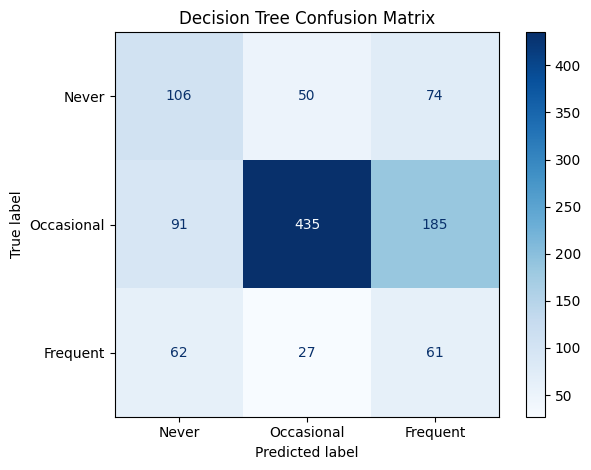

In [55]:
matrix = confusion_matrix(yTest, yPred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Decision Tree Confusion Matrix")
plt.tight_layout()
plt.savefig("images/decision_tree_confusion_matrix.png", dpi=300)
plt.show()
plt.close()

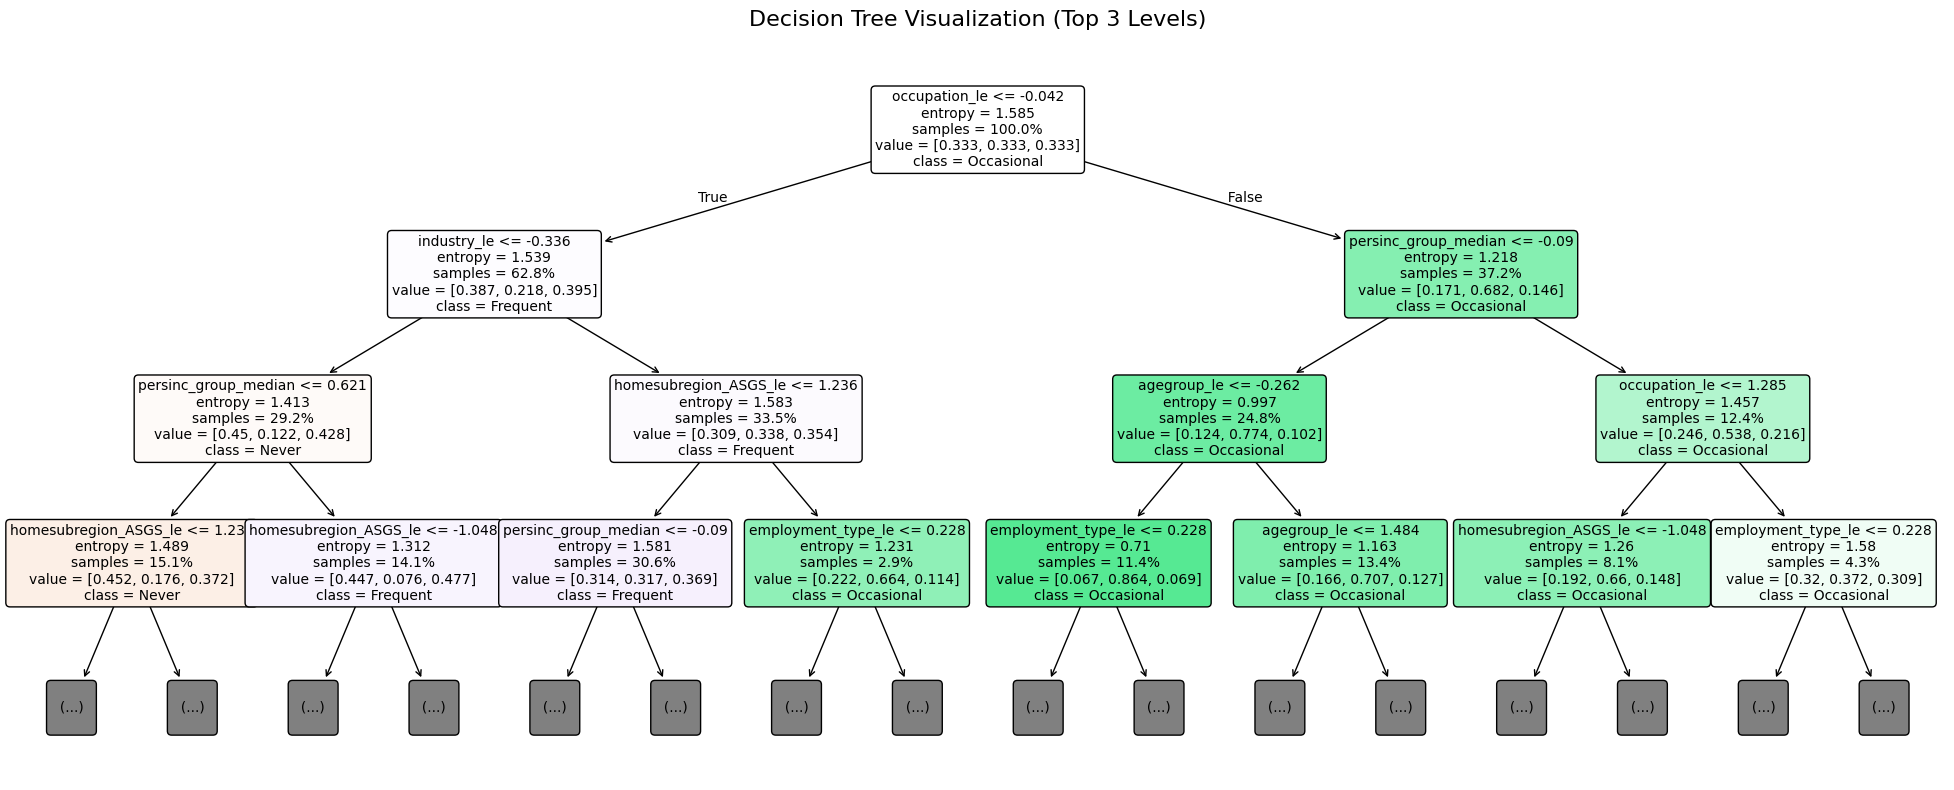

In [56]:
plt.figure(figsize=(20, 8))
plot_tree(decisionTree,
          max_depth=3,
          feature_names=features,
          class_names=labels,
          filled=True,
          rounded=True,
          fontsize=10,
          proportion=True)
plt.title(f'Decision Tree Visualization (Top 3 Levels)\n', fontsize=16)
plt.tight_layout()
plt.savefig('images/decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()